In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

def convert_volume(value):
    if pd.isna(value) or value == '-':
        return 0.0
    value = str(value).upper()
    try:
        if 'K' in value:
            return float(value.replace('K', '').replace(',', '')) * 1000
        if 'M' in value:
            return float(value.replace('M', '').replace(',', '')) * 1000000
        return float(value.replace(',', ''))
    except:
        return 0.0

def load_and_clean_data():
    df_gold = pd.read_csv('Gold Price (2013-2023).csv')
    df_gold['Date'] = pd.to_datetime(df_gold['Date'])
    
    for col in ['Price', 'Open', 'High', 'Low']:
        df_gold[col] = df_gold[col].astype(str).str.replace(',', '').astype(float)
    
    df_gold['Vol.'] = df_gold['Vol.'].apply(convert_volume)
    
    df_gold = df_gold.sort_values('Date').set_index('Date')

    df_market = pd.read_csv('final_data.csv')
    df_market['Date'] = pd.to_datetime(df_market['Date'], dayfirst=True)
    for col in ['USO', 'SLV', 'S&P500', 'EUR/USD']:
        if df_market[col].dtype == 'object':
            df_market[col] = df_market[col].astype(str).str.replace(',', '').astype(float)
    df_market = df_market.sort_values('Date').set_index('Date')

    df_fed = pd.read_csv('FEDFUNDS.csv')
    df_fed['Date'] = pd.to_datetime(df_fed['observation_date'])
    df_fed = df_fed.set_index('Date')[['FEDFUNDS']]

    df_cpi = pd.read_csv('CORESTICKM159SFRBATL.csv')
    df_cpi['Date'] = pd.to_datetime(df_cpi['observation_date'])
    df_cpi = df_cpi.set_index('Date')[['CORESTICKM159SFRBATL']]
    
    return df_gold, df_market, df_fed, df_cpi

df_gold, df_market, df_fed, df_cpi = load_and_clean_data()


In [32]:
full_idx = pd.date_range(start=df_gold.index.min(), end=df_gold.index.max(), freq='D')
df_fed_daily = df_fed.reindex(full_idx, method='ffill')
df_cpi_daily = df_cpi.reindex(full_idx, method='ffill')

df = df_gold.join([df_market, df_fed_daily, df_cpi_daily], how='inner')
df['Real_Rate'] = df['FEDFUNDS'] - df['CORESTICKM159SFRBATL']

# Log Return cho các chỉ số tài chính
features_to_log = ['Price', 'S&P500', 'SLV', 'USO', 'EUR/USD']
for col in features_to_log:
    df[f'{col}_LogRet'] = np.log(df[col] / df[col].shift(1))

df['Vol_Log'] = np.log1p(df['Vol.'])

df = df.dropna()

feature_cols = ['Price_LogRet', 'S&P500_LogRet', 'SLV_LogRet', 'USO_LogRet', 'EUR/USD', 'Real_Rate', 'Vol_Log']
data = df[feature_cols].values

In [33]:
train_size = int(len(data) * 0.9)
train_data_raw = data[:train_size]
test_data_raw = data[train_size:]

# CHỈ FIT SCALER TRÊN TẬP TRAIN
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data_raw)

# Transform riêng biệt
train_scaled = scaler.transform(train_data_raw)
test_scaled = scaler.transform(test_data_raw)

# 4. TẠO DATASET CHO LSTM (X, y)
def create_dataset(dataset_scaled, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset_scaled)):
        X.append(dataset_scaled[i-time_step:i, :])
        y.append(dataset_scaled[i, :])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)

# Để dự báo được ngày đầu tiên của tập Test, ta cần 60 ngày cuối của tập Train làm đầu vào
test_input_combined = np.vstack([train_scaled[-time_step:], test_scaled])
X_test, y_test = create_dataset(test_input_combined, time_step)

# 5. XÂY DỰNG VÀ HUẤN LUYỆN MODEL LSTM
n_features = X_train.shape[2]
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, n_features)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(n_features)
])

model.compile(optimizer='adam', loss='mse')
print("Training LSTM model...")
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)

Training LSTM model...
Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0716
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0306
Epoch 3/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0238
Epoch 4/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0188
Epoch 5/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0168
Epoch 6/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0146
Epoch 7/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0138
Epoch 8/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0126
Epoch 9/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0121
Epoch 10/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0116
Epoch 11/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0114
Epoch 12/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0102
Epoch 13/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0104
Epoch 14/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0100
Epoch 15/150
69/69 ━━━━━━━━━━━━━━━

In [34]:
preds_scaled = model.predict(X_test)
preds_real = scaler.inverse_transform(preds_scaled)
price_preds = []
price_actual = []

prices_yesterday = df['Price'].iloc[train_size - 1 : -1].values

for i in range(len(preds_real)):
    p_hat = prices_yesterday[i] * np.exp(preds_real[i, 0])
    price_preds.append(p_hat)
    price_actual.append(df['Price'].iloc[train_size + i])

rmse = np.sqrt(mean_squared_error(price_actual, price_preds))
mape = mean_absolute_percentage_error(price_actual, price_preds) * 100

actual_diff = np.sign(np.array(price_actual) - prices_yesterday)
pred_diff = np.sign(np.array(price_preds) - prices_yesterday)
directional_acc = np.mean(actual_diff == pred_diff) * 100

print(f"\n" + "="*30)
print(f"WALK-FORWARD LSTM RESULTS:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Directional Accuracy: {directional_acc:.2f}%")
print("="*30)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step

WALK-FORWARD LSTM RESULTS:
RMSE: 17.72
MAPE: 0.75%
Directional Accuracy: 54.37%


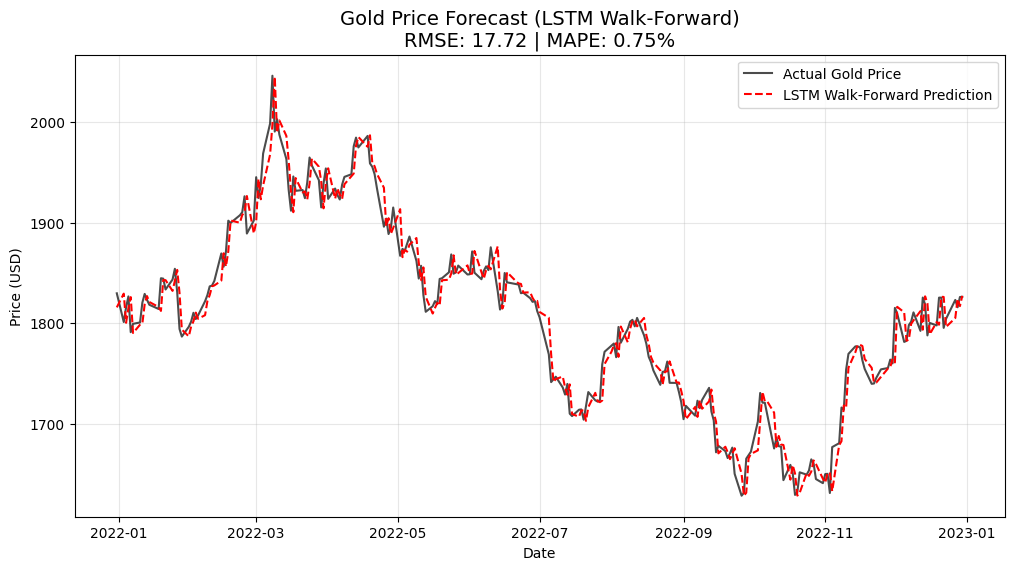

In [35]:
dates_test = df.index[train_size:]

plt.figure(figsize=(12, 6))
plt.plot(dates_test, price_actual, label='Actual Gold Price', color='black', alpha=0.7)
plt.plot(dates_test, price_preds, label='LSTM Walk-Forward Prediction', color='red', linestyle='--')
plt.title(f"Gold Price Forecast (LSTM Walk-Forward)\nRMSE: {rmse:.2f} | MAPE: {mape:.2f}%", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()